# 1. BERT embeddings and Sentiment Analysis using Spark NLP
In this notebook three pipelines are created. The first converts the raw bodyTexts from each Guardian article into vectors ready to be fed into any Spark ML algorithm, using Bert embeddings. The second and third perform a sentiment analysis using a built-in sentiment-analysis pipeline from Spark NLP and using a self-created pipeline incorporating the vivekn-sentiment detector. Installing both Spark NLP and PySpark can be done using the command ```pip install spark-nlp==2.4.5 pyspark==2.4.4``` in the command line.

In the blocks below the **BERT embeddings** pipeline is created and employed.


### 1.0 Importing packages and data

In [1]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
import matplotlib.pyplot as plt
import pandas as pd

# Starting a PySpark session within a Python environment
spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  2.4.5
Apache Spark version:  2.4.4


In the block below the json-file is imported to PySpark sql-format (also referred to within PySpark as DataFrames, not to be confused with pandas DataFrames).

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType

# Schema as created in file 0
schema = StructType([
    StructField("bodyText", StringType(), True),
    StructField("webPublicationDate", TimestampType(), True),
    StructField("wordcount", FloatType(), True),
])

df = spark.read.json('climateChangeArticlesGuardian0019.json', schema)

df = df.withColumnRenamed('bodyText','text')

df.columns

# Separate the df into four dataframes, time periods as described in main pdf-file
df0004 = df.where(df.webPublicationDate.between('2000-01-01','2004-12-31'))
df0509 = df.where(df.webPublicationDate.between('2005-01-01','2009-12-31'))
df1014 = df.where(df.webPublicationDate.between('2010-01-01','2014-12-31'))
df1519 = df.where(df.webPublicationDate.between('2015-01-01','2019-12-04'))

### 1.1 Embeddings pipeline
The pipeline starts with the DocumentAssembler(), which annotates the raw data. Simply stated, this operation converts the bodyTexts into a format which can be used by the upcoming annotators. The Tokenizer() identifies tokens with tokenization open standards. The Normalizer() removes all dirty characters from text following a regex pattern and transforms words based on a set dictionary. The Lemmatizer uses a pretrained lemmatizer to retrieve lemmas out of words with the objective of returning a base dictionary word. The StopWordsCleaner removes all stopwords, provided a dictionary. This dictionary is a combination of nltk stopwords and a manual list of words that appear more than 5,000 times in the dataset and deemed irrelevant by me. The BertEmbeddings operation provides dense vector representations for natural language by using a deep, pre-trained neural network as described in the main pdf, on a sentence level. The SentenceEmbeddings() operation changes the embeddings by averaging all the sentence embeddings from a document, so that the output vector is ready to be fed into a Spark ML operation.

In [3]:
from nltk.corpus import stopwords

stops = list(set(stopwords.words("english"))) + ['something', 'le', 'un', 'could', 'keep', 'thing', 'must', 'find', 'however', 
                  'one', 'really', 'put', 'given', 'whether', 'make', 'way', 'nt', 'told', 'come',
                  'would', 'three', 'give', 'mr', 'like', 'also', 'u', 'rather', 'made', 'mean', 
                  'may', 'seen', 'bodytext', 'set', 'much', 'become', 'two', 'even', 'might', 
                  'around', 'going', 'per', 'many', 'said', 'say']

documentassembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

lemmatizer = LemmatizerModel.pretrained(name="lemma_antbnc", lang="en")\
    .setInputCols(["normalized"]) \
    .setOutputCol("lemma") 

stop_words_cleaner = StopWordsCleaner() \
        .setInputCols(["lemma"]) \
        .setOutputCol("cleanTokens") \
        .setCaseSensitive(False) \
        .setStopWords(stops)

bert = BertEmbeddings.pretrained() \
      .setInputCols("document", "cleanTokens") \
      .setOutputCol("sentence_embeddings")

sentence_embeddings = SentenceEmbeddings() \
            .setInputCols(["document", "sentence_embeddings"]) \
            .setOutputCol("document_embeddings") \
            .setPoolingStrategy("AVERAGE")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
bert_base_cased download started this may take some time.
Approximate size to download 389.2 MB
[OK!]


The code below creates a pipeline. The process of converting the entire dataframe (1,706 raw texts) takes 1.5 seconds in total, as RDD operations are lazy. 

In [4]:
from pyspark.ml import Pipeline
from pyspark.sql.functions import explode
import time

pipeline_embeddings_dl = Pipeline(stages = [
    documentassembler, 
    tokenizer, 
    normalizer,
    lemmatizer,
    stop_words_cleaner,
    bert,
    sentence_embeddings])

start = time.time()
df_new = pipeline_embeddings_dl.fit(df0004).transform(df0004)
df_new = df_new.withColumn("features", explode("document_embeddings.embeddings"))
gd = df_new.select('features')
end = time.time()
print("Time elapsed pipeline process: " + str(end - start))
gd.select('features').show(3)

Time elapsed pipeline process: 1.4899110794067383
+--------------------+
|            features|
+--------------------+
|[0.10004237, -0.2...|
|[0.1185097, -0.09...|
|[0.15904714, -0.0...|
+--------------------+
only showing top 3 rows



The features column is then converted to json-format, to be accessed by PySpark on a Dataproc cluster, so that times to perform an LDA operation are comparable.

### 1.2 Sentiment Analysis
The sentiment pipelines are fairly uncomplicated. The pipeline starts with the DocumentAssembler(), which annotates the raw data. The Tokenizer() identifies tokens with tokenization open standards. The sentiment detector is then ready to analyse the sentiment for each document.

In [82]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document") \
    .setCleanupMode("shrink")

tokenizer_from_doc = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['(', ')', '?', '!']) 

Below the vivekn sentiment-analyser and the pretrained pipeline are downloaded.

In [78]:
sentiment_vivekn = ViveknSentimentModel.pretrained('sentiment_vivekn')
sentiment_sentence_pipeline = PretrainedPipeline("analyze_sentiment", lang="en")

sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]


After which a pipeline is created to infer sentiment. The pre-trained pipeline gives sentiment per sentence, while the vivekn pipeline gives sentiment per document, a somewhat naive approach.

In [102]:
from pyspark.ml import Pipeline
import time
sentiment_document_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer_from_doc,
    sentiment_vivekn
])

start = time.time()
df_pretrained_pipe = sentiment_sentence_pipeline.transform(df)

end = time.time()
print("Time elapsed pipeline process: " + str(end - start))

start = time.time()
df_doc = sentiment_document_pipeline.fit(df).transform(df)
end = time.time()
print("Time elapsed pipeline process: " + str(end - start))

Time elapsed pipeline process: 0.4880204200744629
Time elapsed pipeline process: 0.19527792930603027


The output of both operations is somewhat unintelligble, and thus user-defined functions must be used to infer the sentiment lable. The functions are explained in comments.

In [1]:
import pyspark.sql.functions as F

# countsentimentscore converts the word positive into 1, and negative into -1. 
# This is then summed and divided by the number of sentences, giving a value between -1 and 1.
def countsentimentscore(ls):
    ls_new = [1 if i == 'positive' else -1 for i in ls]
    if len(ls_new) > 0:
        return sum(ls_new)/len(ls_new)
    else:
        return 0

# Creating a udf so that pyspark.sql recognises the function.
udfsent_pre_pipe = F.udf(countsentimentscore, FloatType())


# Select sentiment is a somewhat badly written code that selects the sentiment score 
# coming from the vivekn detector.
def selectsentiment(tuple_within_list):
    tup = [x[3] for x in tuple_within_list]
    if len(tup) > 0:
        return str(tup[0])
    else:
        return 'none'

udfsent = F.udf(selectsentiment, StringType())

NameError: name 'FloatType' is not defined

In [107]:
# The functions are run on the relevant output columns of the pipelines. Afterwards, they are converted
# to pandas so that they can be plotted.
df_pretrained_pipe_upgrade = df_pretrained_pipe.withColumn('sentimentfloatpp', udfsent_pre_pipe('sentiment.result'))
df_doc_upgrade = df_doc.withColumn("sentimentstring", udfsent("sentiment"))
df_doc_upgrade_2 = df_doc_upgrade.withColumn("sentimentfloat",
               F.when(df_doc_upgrade.sentimentstring == 'positive', 1)\
                      .otherwise(-1))
sentimentcolumn_pd_pre_pipe = df_pretrained_pipe_upgrade.select('sentimentfloatpp').toPandas()
sentimentcolumn_pd = df_doc_upgrade_2.select('sentimentfloat').toPandas()

The DataFrame is then converted to pandas and pickled, because these operations both took tens of minutes.

In [2]:
fd = pd.read_pickle('guardianwithsentiment')
guardianpd = fd

Below the sentiment scores for both pipelines are compared. I am assuming that the pipeline assigning a sentiment to each sentence is more sensible. The two detectors seem to give somewhat similar results, yet the number of articles considered positive is much smaller for the pipeline looking at per sentence (2330 < 7882). This does not imply either one is better than the other, as it is not entirely unlikely that 17,140 out of 21,000 articles are negative, since they all pertain to the 'negative' topic of climate change.

In [5]:
print('Number of positive articles',len(guardianpd[guardianpd['sentimentfloatpp'] > 0]))
print('Number of negative articles',len(guardianpd[guardianpd['sentimentfloatpp'] < 0]))

print('Number of positive articles vivekn',len(guardianpd[guardianpd['sentimentfloat'] > 0]))
print('Number of negative articles vivekn',len(guardianpd[guardianpd['sentimentfloat'] < 0]))
guardianpd[['bodyText','sentimentfloat','sentimentfloatpp']].head(10)

Number of positive articles 2330
Number of negative articles 17140
Number of positive articles vivekn 7882
Number of negative articles vivekn 13119


,bodyText,sentimentfloat,sentimentfloatpp
0,About 110 vehicles were involved in a crash ye...,1,0.750000
1,Still struggling to clear up from violent stor...,-1,-0.117647
2,"More than 200,000 British families own homes i...",-1,-0.600000
3,Researchers have discovered that Europe's perm...,1,-0.125000
4,Californians could be forced to revive the tra...,-1,-0.833333
5,It's not just your rose-tinted childhood memor...,-1,-0.090909
6,Tropical cyclone Eline compounded Mozambique's...,1,-0.619048
7,The south of England could soon rival France a...,-1,-0.666667
8,The long hot summer of the cities is here to s...,-1,-0.157895
9,"In Mozambique, 300,000 people are left homeles...",-1,-0.666667


In [47]:
v_positive = guardianpd['sentimentfloatpp'] > 0.7
v_negative = guardianpd['sentimentfloatpp'] < -0.7
print(guardianpd[v_positive]['bodyText'].head(5))
print(guardianpd[v_negative]['bodyText'].head(5))

0       About 110 vehicles were involved in a crash ye...
391     Environmentalists last night warned they would...
560     Gale force winds of more than 90mph caused tra...
909     A landslide caused by heavy rain led to a trai...
2086    A mass evacuation of tourists in one of the wo...
Name: bodyText, dtype: object
4      Californians could be forced to revive the tra...
59     Floods, droughts and storms have dramatically ...
210    After the gales that turned seaside caravans i...
296    An attempt by the World Economic Forum to rank...
354    Charles Kennedy yesterday moved to raise his p...
Name: bodyText, dtype: object
Number of positive articles 2330
Number of negative articles 17140
Number of positive articles vivekn 7882
Number of negative articles vivekn 13119


The positive articles as labelled by the sentence pipeline are about a motorway crash, an Esso boycot, gale force winds, a landslide, and a mass evacuation. This seems somewhat unlikely. The sentiment detector is somewhat limited in scope. Below the plots are created.


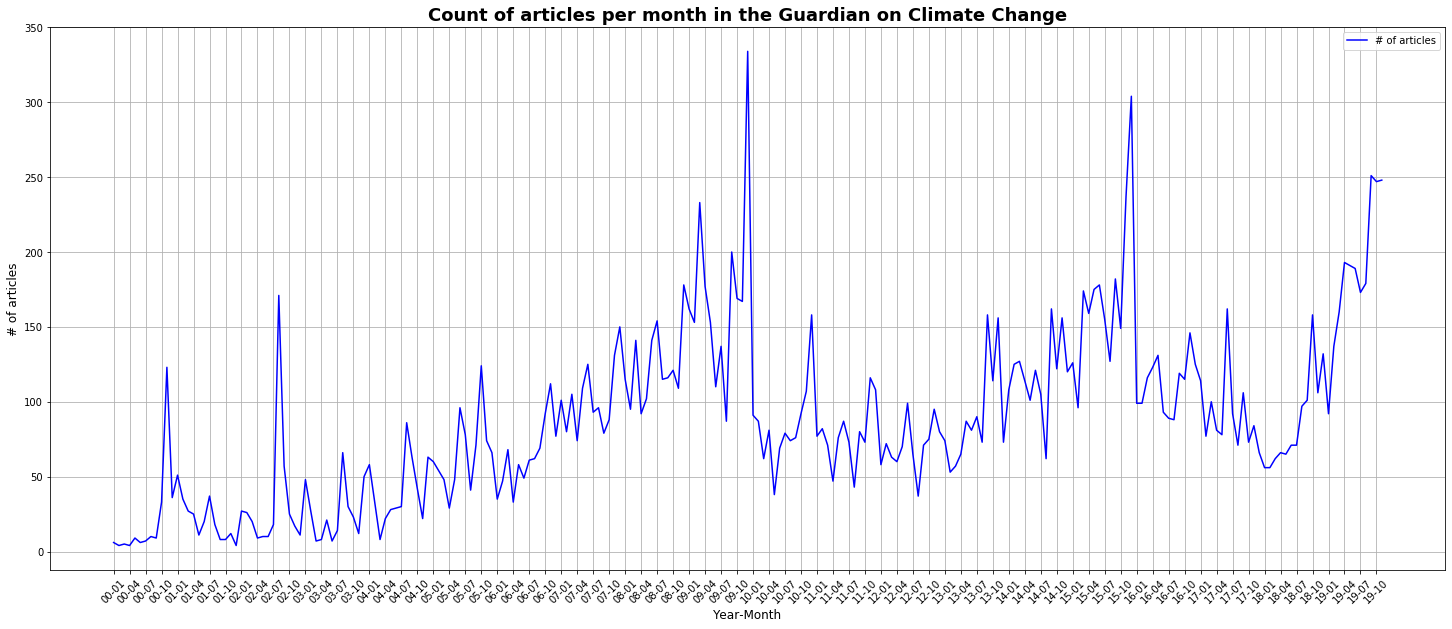

In [4]:
import matplotlib.pyplot as plt
per_month_cnt_guardian = pd.DataFrame(guardianpd.groupby('month')['id'].count())

f = plt.figure(figsize=(25,10))
plt.plot(per_month_cnt_guardian.index[:-1], per_month_cnt_guardian['id'][:-1], label = '# of articles', color = 'blue')

plt.xticks(per_month_cnt_guardian.index[::3], rotation = 45, fontsize = 10)
plt.xlabel('Year-Month', fontsize = 12)
plt.ylabel('# of articles', fontsize = 12)
plt.title('Count of articles per month in the Guardian on Climate Change', fontweight = 'bold', fontsize = 18)
plt.legend()
plt.grid(b=None)
plt.show()

f.savefig('article_count.pdf')

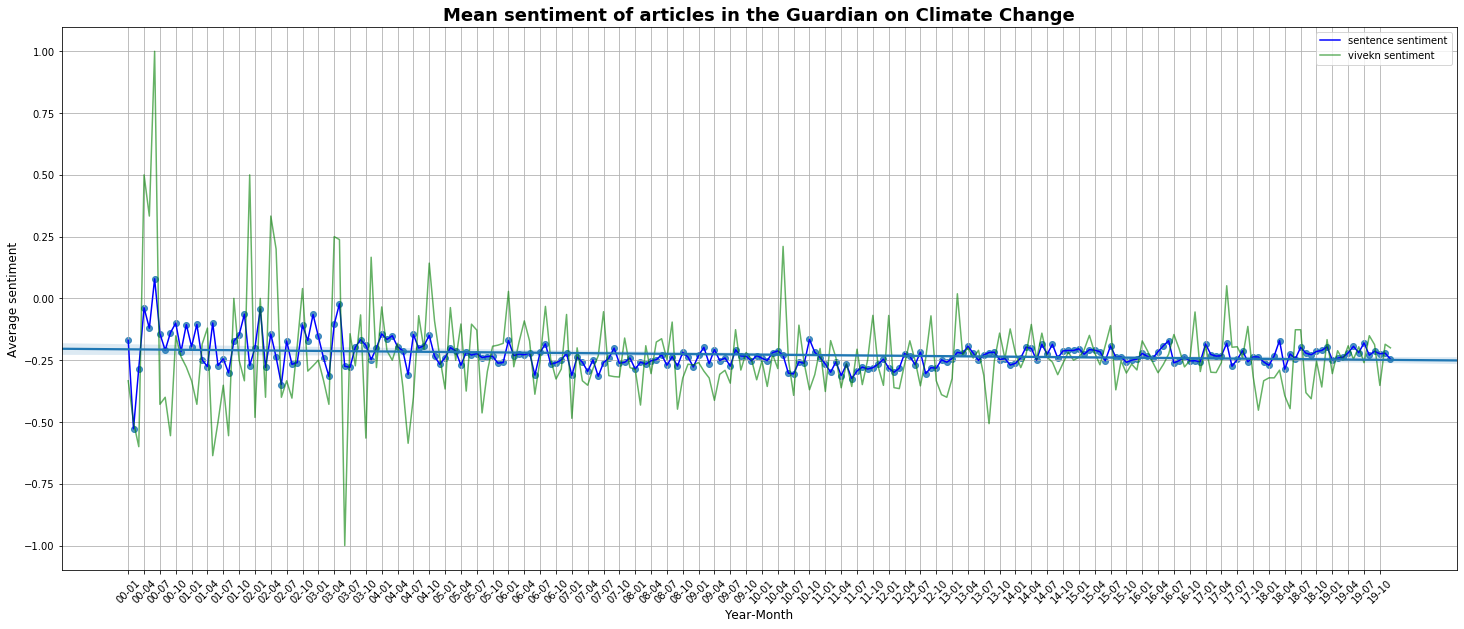

In [5]:
# Taking the mean sentiment of each month
sentiment_per_month = pd.DataFrame(guardianpd.groupby('month')['sentimentfloatpp'].mean())
sentiment_per_month_naive = pd.DataFrame(guardianpd.groupby('month')['sentimentfloat'].mean())
sentiment_per_month['id_new'] = range(0, len(sentiment_per_month))

f = plt.figure(figsize=(25,10))
plt.plot(sentiment_per_month.index, sentiment_per_month['sentimentfloatpp'], label = 'sentence sentiment', color = 'blue')
plt.plot(sentiment_per_month_naive.index, sentiment_per_month_naive['sentimentfloat'], label = 'vivekn sentiment', color = 'green', alpha = 0.6)

import seaborn as sns
# Create trendline
sns.regplot(x='id_new',y='sentimentfloatpp',data=sentiment_per_month, fit_reg=True) 

plt.xticks(sentiment_per_month.index[::3], rotation = 45, fontsize = 10)
plt.xlabel('Year-Month', fontsize = 12)
plt.ylabel('Average sentiment', fontsize = 12)
plt.title('Mean sentiment of articles in the Guardian on Climate Change', fontweight = 'bold', fontsize = 18)
plt.legend()
plt.grid(b=None)
plt.show()
f.savefig('sentiment_mean.pdf')

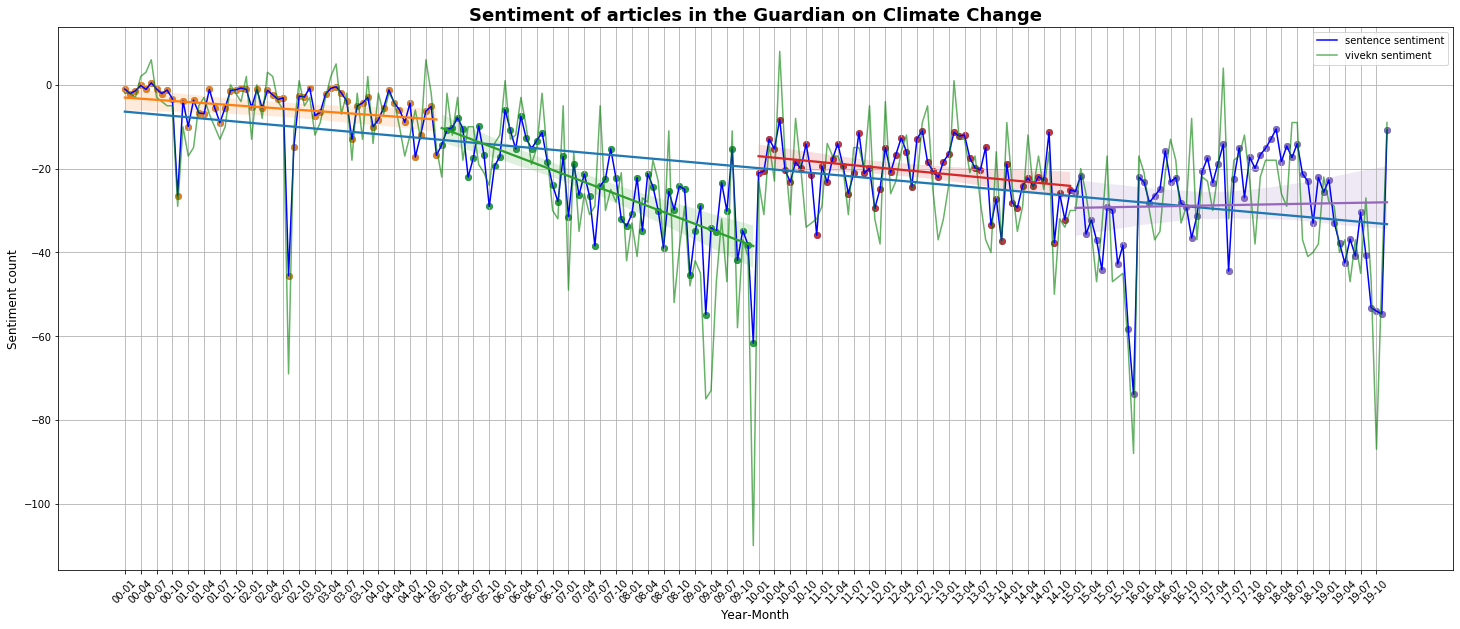

In [6]:
sentiment_per_month_ct = pd.DataFrame(guardianpd.groupby('month')['sentimentfloatpp'].sum())
sentiment_per_month_naive_ct = pd.DataFrame(guardianpd.groupby('month')['sentimentfloat'].sum())
sentiment_per_month_ct['id_new'] = range(0, len(sentiment_per_month_ct))


f = plt.figure(figsize=(25,10))
plt.plot(sentiment_per_month_ct.index, sentiment_per_month_ct['sentimentfloatpp'], label = 'sentence sentiment', color = 'blue')
plt.plot(sentiment_per_month_naive_ct.index, sentiment_per_month_naive_ct['sentimentfloat'], label = 'vivekn sentiment', color = 'green', alpha = 0.6)

epoch1 = sentiment_per_month_ct[:len(sentiment_per_month_ct)//4]
epoch2 = sentiment_per_month_ct[len(sentiment_per_month_ct)//4:len(sentiment_per_month_ct)//2]
epoch3 = sentiment_per_month_ct[len(sentiment_per_month_ct)//2:(len(sentiment_per_month_ct)*3)//4]
epoch4 = sentiment_per_month_ct[(len(sentiment_per_month_ct)*3)//4:]
sns.regplot(x='id_new',y='sentimentfloatpp',data=sentiment_per_month_ct, fit_reg=True, truncate = True, ci = None) 
sns.regplot(x='id_new',y='sentimentfloatpp',data=epoch1, fit_reg=True, truncate = True) 
sns.regplot(x='id_new',y='sentimentfloatpp',data=epoch2, fit_reg=True, truncate = True) 
sns.regplot(x='id_new',y='sentimentfloatpp',data=epoch3, fit_reg=True, truncate = True) 
sns.regplot(x='id_new',y='sentimentfloatpp',data=epoch4, fit_reg=True, truncate = True) 

plt.xticks(sentiment_per_month.index[::3], rotation = 45, fontsize = 10)
plt.xlabel('Year-Month', fontsize = 12)
plt.ylabel('Sentiment count', fontsize = 12)
plt.title('Sentiment of articles in the Guardian on Climate Change', fontweight = 'bold', fontsize = 18)
plt.legend()
plt.grid(b=None)
#plt.show()
f.savefig('sentiment_count.pdf')